# Synthetic Data Generation for Contrastive Learning

## Overview
This notebook generates synthetic genomic embedding data with matched case-control structure for testing the contrastive learning pipeline. The synthetic data mimics real-world scenarios where:
- Embeddings are pre-computed for multiple genes (each gene has 1024 features)
- Cases and controls are matched in groups (1 case + 4 controls per group)
- Confounding variables (ancestry, technical factors) correlate with embeddings
- The outcome label has signal that can be learned via contrastive learning

## Data Structure
- **Embeddings**: Shape `(n_samples, 1024 * n_genes)` that can be reshaped to `(n_samples, 1024, n_genes)`
- **Labels**: `is_positive` (binary outcome)
- **Matching**: `case_matched` column groups cases with their matched controls
- **Confounders**: ancestry, demographics, and technical variables
- **Split**: Train/test split at the matched group level to prevent leakage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

## Configuration

Define the structure of our synthetic dataset:
- Number of matched case-control groups
- Number of genes to include (each with 1024-dimensional embeddings)
- Train/test split ratio
- Effect sizes for confounders and outcome signal

In [2]:
# Data generation parameters
N_MATCHED_GROUPS = 200  # Number of case-control matched groups
N_CONTROLS_PER_CASE = 4  # Controls per case
N_SAMPLES = N_MATCHED_GROUPS * (1 + N_CONTROLS_PER_CASE)  # Total samples

# Embedding structure
GENE_DIM = 1024  # Features per gene
N_GENES = 10  # Number of genes (e.g., SIRPG, BACH2)
GENE_NAMES = [
    "α-syn",
    "β-k3",
    "γ-DR",
    "ε-BP",
    "λ-trans7",
    "ζ-lig",
    "ω-deg",
    "κ-pol",
    "η-rec",
    "δ-act2",
    "θ-phos",
    "μ-chan",
    "ξ-meth",
    "π-ox",
    "ρ-hydr",
    "σ-cat",
    "τ-tub",
    "υ-reg",
    "φ-fold",
    "χ-chap",
    "ψ-sens",
][:N_GENES]

# Effect sizes
CONFOUNDER_EFFECT = 2.0  # How much confounders affect embeddings
OUTCOME_EFFECT = 1.5  # How much outcome affects embeddings
NOISE_SCALE = 2.0  # Scale of random noise

# Train/test split
TRAIN_RATIO = 0.8

# Output path
OUTPUT_DIR = Path("../data")
OUTPUT_DIR.mkdir(exist_ok=True)
OUTPUT_FILE = OUTPUT_DIR / "synthetic_embeddings.parquet"

print(f"Generating {N_SAMPLES} samples with {N_MATCHED_GROUPS} matched groups")
print(
    f"Embedding dimension: {GENE_DIM} x {N_GENES} genes = {GENE_DIM * N_GENES} total features"
)

Generating 1000 samples with 200 matched groups
Embedding dimension: 1024 x 10 genes = 10240 total features


## Generate Matched Case-Control Structure

Create the basic structure with:
- Unique sample IDs
- Case/control labels (`is_positive`)
- Matched group IDs (`case_matched`)
- Each group has 1 case (is_positive=1) and 4 controls (is_positive=0)

In [3]:
# Initialize data structure
data = []

for group_id in range(N_MATCHED_GROUPS):
    # One case per group
    data.append(
        {
            "sample_id": f"sample_{group_id * 5}",
            "case_matched": f"group_{group_id}",
            "is_positive": 1,
            "case_id": f"case_{group_id}",
        }
    )

    # Four controls per group
    for control_idx in range(N_CONTROLS_PER_CASE):
        data.append(
            {
                "sample_id": f"sample_{group_id * 5 + control_idx + 1}",
                "case_matched": f"group_{group_id}",
                "is_positive": 0,
                "case_id": f"case_{group_id}",  # Same case_id for matched controls
            }
        )

df = pd.DataFrame(data)

# Assign train/test split at group level (prevent leakage)
n_train_groups = int(N_MATCHED_GROUPS * TRAIN_RATIO)
train_groups = [f"group_{i}" for i in range(n_train_groups)]
df["split"] = df["case_matched"].apply(
    lambda x: "train" if x in train_groups else "test"
)

print(f"Created {len(df)} samples:")
print(f"  Cases: {df['is_positive'].sum()}")
print(f"  Controls: {(1 - df['is_positive']).sum()}")
print(f"  Train samples: {(df['split'] == 'train').sum()}")
print(f"  Test samples: {(df['split'] == 'test').sum()}")

Created 1000 samples:
  Cases: 200
  Controls: 800
  Train samples: 800
  Test samples: 200


## Generate Confounding Variables

Create confounders that will correlate with the embeddings:
- **is_female**: Binary sex indicator
- **is_european**: Ancestry indicator (vs non-European)
- **is_gt_65_years**: Age indicator (>65 years)
- **vcf_assay_version**: Technical batch variable (versions 1-3)
- **is_bmi_gt_30**: BMI indicator (obese)

These confounders are matched within groups to simulate realistic case-control matching.

In [4]:
# Generate confounders at the group level (matched within groups)
confounder_data = []

for group_id in range(N_MATCHED_GROUPS):
    # Sample group-level confounders (shared across matched set)
    group_confounders = {
        "is_female": np.random.binomial(1, 0.5),
        "is_european": np.random.binomial(1, 0.6),
        "is_gt_65_years": np.random.binomial(1, 0.3),
        "vcf_assay_version": np.random.choice([1, 2, 3]),
        "is_bmi_gt_30": np.random.binomial(1, 0.25),
    }

    # Repeat for all samples in the group (1 case + 4 controls)
    for _ in range(1 + N_CONTROLS_PER_CASE):
        confounder_data.append(group_confounders.copy())

# Add confounders to dataframe
for col, values in pd.DataFrame(confounder_data).items():
    df[col] = values.values

print("Confounder distributions:")
for col in ["is_female", "is_european", "is_gt_65_years", "is_bmi_gt_30"]:
    print(f"  {col}: {df[col].mean():.2%}")
print(f"\nAssay version distribution:")
print(df["vcf_assay_version"].value_counts().sort_index())

Confounder distributions:
  is_female: 55.50%
  is_european: 62.50%
  is_gt_65_years: 28.50%
  is_bmi_gt_30: 23.50%

Assay version distribution:
vcf_assay_version
1    340
2    355
3    305
Name: count, dtype: int64


## Generate Synthetic Embeddings

Create realistic embeddings that:
1. Have structure from confounding variables (ancestry, batch effects)
2. Contain signal related to the outcome (`is_positive`)
3. Have random noise to simulate biological variability

Each gene gets 1024-dimensional embeddings, and the embeddings are structured so that:
- Confounders create strong patterns (simulating batch effects)
- The outcome has a weaker but learnable signal
- Samples within matched groups are more similar than across groups

In [5]:
# Create embedding matrix
embeddings = np.zeros((N_SAMPLES, GENE_DIM, N_GENES))

# Generate base embeddings for each gene
for gene_idx in range(N_GENES):
    # Start with random baseline
    embeddings[:, :, gene_idx] = np.random.randn(N_SAMPLES, GENE_DIM) * NOISE_SCALE

    # Add confounder effects (different patterns for each confounder)
    # Ancestry effect
    ancestry_pattern = np.random.randn(GENE_DIM) * CONFOUNDER_EFFECT
    embeddings[:, :, gene_idx] += (
        df["is_european"].values[:, None] * ancestry_pattern[None, :]
    )

    # Sex effect
    sex_pattern = np.random.randn(GENE_DIM) * CONFOUNDER_EFFECT * 0.7
    embeddings[:, :, gene_idx] += df["is_female"].values[:, None] * sex_pattern[None, :]

    # Age effect
    age_pattern = np.random.randn(GENE_DIM) * CONFOUNDER_EFFECT * 0.5
    embeddings[:, :, gene_idx] += (
        df["is_gt_65_years"].values[:, None] * age_pattern[None, :]
    )

    # Batch effect (assay version)
    for version in [1, 2, 3]:
        batch_pattern = np.random.randn(GENE_DIM) * CONFOUNDER_EFFECT * 0.8
        mask = (df["vcf_assay_version"] == version).values
        embeddings[mask, :, gene_idx] += batch_pattern[None, :]

    # Add outcome signal (weaker than confounders, but learnable)
    outcome_pattern = np.random.randn(GENE_DIM) * OUTCOME_EFFECT
    embeddings[:, :, gene_idx] += (
        df["is_positive"].values[:, None] * outcome_pattern[None, :]
    )

    # Add matched group similarity (samples in same group are more similar)
    for group in df["case_matched"].unique():
        group_mask = (df["case_matched"] == group).values
        group_pattern = np.random.randn(GENE_DIM) * 0.5
        embeddings[group_mask, :, gene_idx] += group_pattern[None, :]

print(f"Generated embeddings with shape: {embeddings.shape}")
print(
    f"  (n_samples={embeddings.shape[0]}, gene_dim={embeddings.shape[1]}, n_genes={embeddings.shape[2]})"
)

Generated embeddings with shape: (1000, 1024, 10)
  (n_samples=1000, gene_dim=1024, n_genes=10)


## Store Embeddings in Dataframe

Store each gene's embeddings as a single column containing numpy arrays (dtype=object). This is more efficient than spreading the 1024 features across separate columns.

In [6]:
# Add each gene's embeddings as a single column (dtype=object containing np.array)
for gene_idx, gene_name in enumerate(GENE_NAMES):
    # Each cell contains a 1D numpy array of shape (1024,)
    df[gene_name] = [embeddings[i, :, gene_idx] for i in range(N_SAMPLES)]

df_final = df.copy()

print(f"Final dataframe shape: {df_final.shape}")
print(f"  Metadata columns: {len(df.columns) - N_GENES}")
print(f"  Gene embedding columns: {N_GENES}")
print(f"\nColumn names:")
print(f"  Metadata: {[c for c in df_final.columns if c not in GENE_NAMES]}")
print(f"  Gene columns: {GENE_NAMES}")
print(f"\nEmbedding column dtypes:")
for gene_name in GENE_NAMES:
    print(
        f"  {gene_name}: {df_final[gene_name].dtype}, example shape: {df_final[gene_name].iloc[0].shape}"
    )

Final dataframe shape: (1000, 20)
  Metadata columns: 10
  Gene embedding columns: 10

Column names:
  Metadata: ['sample_id', 'case_matched', 'is_positive', 'case_id', 'split', 'is_female', 'is_european', 'is_gt_65_years', 'vcf_assay_version', 'is_bmi_gt_30']
  Gene columns: ['α-syn', 'β-k3', 'γ-DR', 'ε-BP', 'λ-trans7', 'ζ-lig', 'ω-deg', 'κ-pol', 'η-rec', 'δ-act2']

Embedding column dtypes:
  α-syn: object, example shape: (1024,)
  β-k3: object, example shape: (1024,)
  γ-DR: object, example shape: (1024,)
  ε-BP: object, example shape: (1024,)
  λ-trans7: object, example shape: (1024,)
  ζ-lig: object, example shape: (1024,)
  ω-deg: object, example shape: (1024,)
  κ-pol: object, example shape: (1024,)
  η-rec: object, example shape: (1024,)
  δ-act2: object, example shape: (1024,)


In [7]:
df_final.head()

,sample_id,case_matched,is_positive,case_id,split,is_female,is_european,is_gt_65_years,vcf_assay_version,is_bmi_gt_30,α-syn,β-k3,γ-DR,ε-BP,λ-trans7,ζ-lig,ω-deg,κ-pol,η-rec,δ-act2
0,sample_0,group_0,1,case_0,train,0,0,1,1,0,"[0.9922476147893728, 0.06271822899207542, 5.01...","[8.760053747528476, 2.7844383837086255, -0.613...","[-1.191079904586615, -3.102762861531924, -3.18...","[1.1188204336341905, -0.44410163291607896, -3....","[-1.410603876173441, 1.9542516985354321, 3.645...","[2.6822087787227207, 3.5918801044209094, -0.95...","[2.488024466822794, 1.3859503496553631, 4.2399...","[-0.34267457633901344, 2.616314397144956, -0.3...","[-3.614945715525132, 1.7609808199644068, -0.45...","[-2.396346728284112, -0.4239394384335931, 3.84..."
1,sample_1,group_0,0,case_0,train,0,0,1,1,0,"[0.22349687651217515, -0.4176291740225309, 2.5...","[5.6880390606073075, 3.2328505481214007, 3.629...","[1.0371299928008637, -1.6392713453933296, -1.1...","[-1.4025230755612925, -0.20570923517195683, 0....","[-2.170296130881664, 1.859084308454974, 1.9174...","[1.4980379031272248, 0.8312872189192245, 0.651...","[1.9055417366654783, 1.7151535770361042, 4.642...","[2.690268224372466, 1.1485603945947547, 2.7942...","[-0.638500290040702, 1.7736344925813452, 0.803...","[1.8718491831790267, -0.7261986644245533, 0.36..."
2,sample_2,group_0,0,case_0,train,0,0,1,1,0,"[3.7232911191590268, -5.974503320378629, 1.923...","[1.7806643675602458, 2.282802272367311, 1.7147...","[1.1241666334704774, -4.881342908655124, -1.26...","[-0.6778837079012161, 1.1736198079453173, 2.00...","[1.515639144901443, 2.6112072130870825, -2.224...","[-0.10820595859307801, 0.3323909129337249, -1....","[0.870913777339655, 1.3287784436659802, 4.9343...","[1.823457452369909, 1.1139316325092607, 3.4746...","[-0.29903491580180525, 4.584548050923178, 1.63...","[-2.2790342934309984, -1.1293186578865566, 1.0..."
3,sample_3,group_0,0,case_0,train,0,0,1,1,0,"[1.7549447356488084, 1.6665544823573004, 3.824...","[1.7136095948124899, 4.652653334858796, 2.1919...","[-1.3781308002637052, -2.8290930095025835, -2....","[-2.4306811255762373, 0.8285242300876813, 5.88...","[-2.861145814667075, -1.5944806924658612, -1.7...","[1.2098969632606522, 5.146699997534295, -2.967...","[1.730425761935023, -0.629360939440194, 0.9445...","[-0.19952557694797207, -1.079144664828748, -0....","[-3.9865078396974667, -0.6908529827960783, 3.1...","[-0.4195824228942048, 5.042554479260521, 0.562..."
4,sample_4,group_0,0,case_0,train,0,0,1,1,0,"[-0.6861593706438831, 0.1286643772557416, 2.83...","[0.6066298405489212, 1.9633967105747516, 3.635...","[6.194933363177207, -3.779982250037533, 3.6898...","[-0.7082027911266635, 0.5884003083751451, 4.54...","[-1.3212473266272835, 0.2903853207415654, 1.48...","[0.35319674181269367, 0.6776808824396027, 2.05...","[-0.6692295358860461, -1.0420840050889737, 4.3...","[-2.2664275750923744, -1.2653835379736198, -0....","[-1.6165020728768422, -1.6470105487569338, 1.5...","[-0.4723440403927711, -2.2169963093437874, 0.1..."


In [8]:
# Save to parquet
df_final.to_parquet(OUTPUT_FILE, index=False)
print(f"Saved synthetic data to: {OUTPUT_FILE}")
print(f"File size: {OUTPUT_FILE.stat().st_size / 1024 / 1024:.2f} MB")

Saved synthetic data to: ../data/synthetic_embeddings.parquet
File size: 80.82 MB


## Visualize Synthetic Data Quality

Verify that our synthetic data has the expected structure:
1. Check PCA of embeddings shows separation by confounders
2. Verify matched case-control structure
3. Visualize outcome signal in embeddings

In [9]:
# Extract embeddings from dataframe and flatten for PCA
# Stack all gene embeddings: (n_samples, gene_dim * n_genes)
embeddings_flat = np.column_stack(
    [df_final[gene_name].values for gene_name in GENE_NAMES]
)
embeddings_flat = np.vstack(
    [np.concatenate(row) for row in embeddings_flat.reshape(N_SAMPLES, N_GENES)]
)

# Run PCA on flattened embeddings
pca = PCA(n_components=10, random_state=42)
pca_embeddings = pca.fit_transform(embeddings_flat)

# Add PCA components to dataframe for plotting
df_plot = df.copy()
df_plot["PC1"] = pca_embeddings[:, 0]
df_plot["PC2"] = pca_embeddings[:, 1]

print(f"Extracted embeddings shape for PCA: {embeddings_flat.shape}")
print(f"\nPCA explained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"  PC{i+1}: {var:.2%}")
print(f"  Total (first 5 PCs): {pca.explained_variance_ratio_[:5].sum():.2%}")

Extracted embeddings shape for PCA: (1000, 10240)

PCA explained variance ratio:
  PC1: 12.33%
  PC2: 11.14%
  PC3: 10.31%
  PC4: 6.12%
  PC5: 4.60%
  Total (first 5 PCs): 44.51%


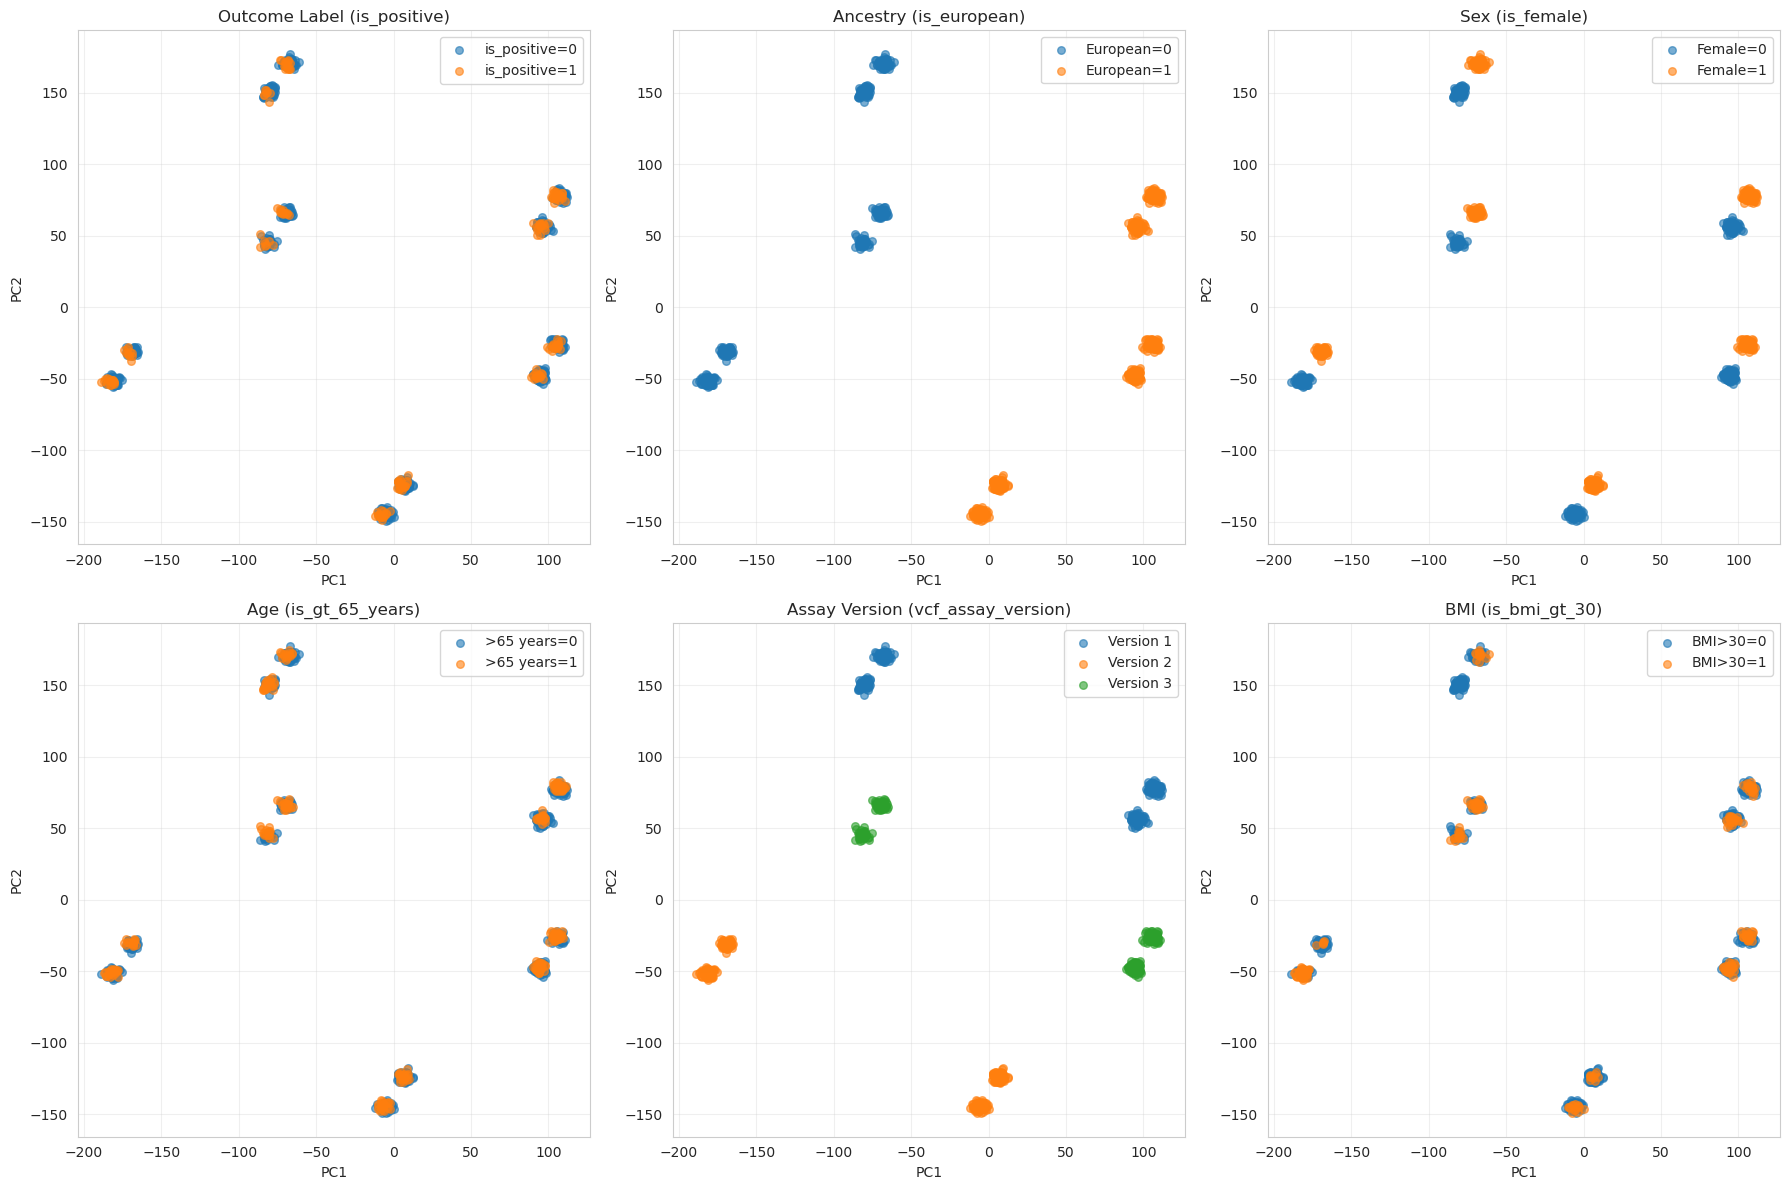

Saved visualization to: ../data/synthetic_data_pca_overview.png


In [10]:
# Plot PC1 vs PC2 colored by various factors
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot 1: Outcome label
for label in [0, 1]:
    mask = df_plot["is_positive"] == label
    axes[0].scatter(
        df_plot.loc[mask, "PC1"],
        df_plot.loc[mask, "PC2"],
        alpha=0.6,
        label=f"is_positive={label}",
        s=30,
    )
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title("Outcome Label (is_positive)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Ancestry
for anc in [0, 1]:
    mask = df_plot["is_european"] == anc
    axes[1].scatter(
        df_plot.loc[mask, "PC1"],
        df_plot.loc[mask, "PC2"],
        alpha=0.6,
        label=f"European={anc}",
        s=30,
    )
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title("Ancestry (is_european)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Sex
for sex in [0, 1]:
    mask = df_plot["is_female"] == sex
    axes[2].scatter(
        df_plot.loc[mask, "PC1"],
        df_plot.loc[mask, "PC2"],
        alpha=0.6,
        label=f"Female={sex}",
        s=30,
    )
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")
axes[2].set_title("Sex (is_female)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Plot 4: Age
for age in [0, 1]:
    mask = df_plot["is_gt_65_years"] == age
    axes[3].scatter(
        df_plot.loc[mask, "PC1"],
        df_plot.loc[mask, "PC2"],
        alpha=0.6,
        label=f">65 years={age}",
        s=30,
    )
axes[3].set_xlabel("PC1")
axes[3].set_ylabel("PC2")
axes[3].set_title("Age (is_gt_65_years)")
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# Plot 5: Assay version (batch)
for version in [1, 2, 3]:
    mask = df_plot["vcf_assay_version"] == version
    axes[4].scatter(
        df_plot.loc[mask, "PC1"],
        df_plot.loc[mask, "PC2"],
        alpha=0.6,
        label=f"Version {version}",
        s=30,
    )
axes[4].set_xlabel("PC1")
axes[4].set_ylabel("PC2")
axes[4].set_title("Assay Version (vcf_assay_version)")
axes[4].legend()
axes[4].grid(True, alpha=0.3)

# Plot 6: BMI
for bmi in [0, 1]:
    mask = df_plot["is_bmi_gt_30"] == bmi
    axes[5].scatter(
        df_plot.loc[mask, "PC1"],
        df_plot.loc[mask, "PC2"],
        alpha=0.6,
        label=f"BMI>30={bmi}",
        s=30,
    )
axes[5].set_xlabel("PC1")
axes[5].set_ylabel("PC2")
axes[5].set_title("BMI (is_bmi_gt_30)")
axes[5].legend()
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    OUTPUT_DIR / "synthetic_data_pca_overview.png", dpi=150, bbox_inches="tight"
)
plt.show()

print(f"Saved visualization to: {OUTPUT_DIR / 'synthetic_data_pca_overview.png'}")

## Verify Matched Case-Control Structure

Check that each matched group has the expected 1:4 case:control ratio and that confounders are properly matched within groups.

In [11]:
# Check matched structure
group_summary = df.groupby("case_matched").agg(
    {
        "is_positive": ["sum", "count"],
        "is_european": lambda x: x.nunique(),  # Should be 1 (matched)
        "is_female": lambda x: x.nunique(),
        "vcf_assay_version": lambda x: x.nunique(),
    }
)

group_summary.columns = [
    "n_cases",
    "group_size",
    "unique_ancestry",
    "unique_sex",
    "unique_batch",
]

print("Matched group structure:")
print(f"  Total groups: {len(group_summary)}")
print(f"  Expected cases per group: 1")
print(f"  Actual cases per group (mean): {group_summary['n_cases'].mean():.2f}")
print(f"  Expected group size: {1 + N_CONTROLS_PER_CASE}")
print(f"  Actual group size (all): {group_summary['group_size'].unique()}")
print(f"\nConfounder matching within groups:")
print(
    f"  Groups with >1 ancestry value: {(group_summary['unique_ancestry'] > 1).sum()}"
)
print(f"  Groups with >1 sex value: {(group_summary['unique_sex'] > 1).sum()}")
print(f"  Groups with >1 batch value: {(group_summary['unique_batch'] > 1).sum()}")
print(f"\n(All should be 0 for proper matching)")

Matched group structure:
  Total groups: 200
  Expected cases per group: 1
  Actual cases per group (mean): 1.00
  Expected group size: 5
  Actual group size (all): [5]

Confounder matching within groups:
  Groups with >1 ancestry value: 0
  Groups with >1 sex value: 0
  Groups with >1 batch value: 0

(All should be 0 for proper matching)


## Summary Statistics

Final summary of the generated synthetic dataset.

In [12]:
print("=" * 60)
print("SYNTHETIC DATA GENERATION SUMMARY")
print("=" * 60)
print(f"\nDataset Statistics:")
print(f"  Total samples: {len(df_final)}")
print(f"  Cases: {df_final['is_positive'].sum()}")
print(f"  Controls: {(1 - df_final['is_positive']).sum()}")
print(f"  Matched groups: {df_final['case_matched'].nunique()}")
print(f"  Train samples: {(df_final['split'] == 'train').sum()}")
print(f"  Test samples: {(df_final['split'] == 'test').sum()}")

print(f"\nEmbedding Structure:")
print(f"  Genes: {N_GENES} ({', '.join(GENE_NAMES)})")
print(f"  Features per gene: {GENE_DIM}")
print(f"  Total features: {GENE_DIM * N_GENES}")
print(f"  Storage format: Each gene = 1 column (dtype=object, containing np.array)")
print(f"  Total columns: {len(df_final.columns)} (metadata + gene columns)")

print(f"\nConfounder Prevalence:")
for col in ["is_female", "is_european", "is_gt_65_years", "is_bmi_gt_30"]:
    print(f"  {col}: {df_final[col].mean():.1%}")
print(f"\nAssay Version Distribution:")
for version in [1, 2, 3]:
    count = (df_final["vcf_assay_version"] == version).sum()
    print(f"  Version {version}: {count} ({count/len(df_final):.1%})")

print(f"\nOutput:")
print(f"  File: {OUTPUT_FILE}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024 / 1024:.2f} MB")
print("\n" + "=" * 60)

SYNTHETIC DATA GENERATION SUMMARY

Dataset Statistics:
  Total samples: 1000
  Cases: 200
  Controls: 800
  Matched groups: 200
  Train samples: 800
  Test samples: 200

Embedding Structure:
  Genes: 10 (α-syn, β-k3, γ-DR, ε-BP, λ-trans7, ζ-lig, ω-deg, κ-pol, η-rec, δ-act2)
  Features per gene: 1024
  Total features: 10240
  Storage format: Each gene = 1 column (dtype=object, containing np.array)
  Total columns: 20 (metadata + gene columns)

Confounder Prevalence:
  is_female: 55.5%
  is_european: 62.5%
  is_gt_65_years: 28.5%
  is_bmi_gt_30: 23.5%

Assay Version Distribution:
  Version 1: 340 (34.0%)
  Version 2: 355 (35.5%)
  Version 3: 305 (30.5%)

Output:
  File: ../data/synthetic_embeddings.parquet
  Size: 80.82 MB



In [13]:
df.head(6)

,sample_id,case_matched,is_positive,case_id,split,is_female,is_european,is_gt_65_years,vcf_assay_version,is_bmi_gt_30,α-syn,β-k3,γ-DR,ε-BP,λ-trans7,ζ-lig,ω-deg,κ-pol,η-rec,δ-act2
0,sample_0,group_0,1,case_0,train,0,0,1,1,0,"[0.9922476147893728, 0.06271822899207542, 5.01...","[8.760053747528476, 2.7844383837086255, -0.613...","[-1.191079904586615, -3.102762861531924, -3.18...","[1.1188204336341905, -0.44410163291607896, -3....","[-1.410603876173441, 1.9542516985354321, 3.645...","[2.6822087787227207, 3.5918801044209094, -0.95...","[2.488024466822794, 1.3859503496553631, 4.2399...","[-0.34267457633901344, 2.616314397144956, -0.3...","[-3.614945715525132, 1.7609808199644068, -0.45...","[-2.396346728284112, -0.4239394384335931, 3.84..."
1,sample_1,group_0,0,case_0,train,0,0,1,1,0,"[0.22349687651217515, -0.4176291740225309, 2.5...","[5.6880390606073075, 3.2328505481214007, 3.629...","[1.0371299928008637, -1.6392713453933296, -1.1...","[-1.4025230755612925, -0.20570923517195683, 0....","[-2.170296130881664, 1.859084308454974, 1.9174...","[1.4980379031272248, 0.8312872189192245, 0.651...","[1.9055417366654783, 1.7151535770361042, 4.642...","[2.690268224372466, 1.1485603945947547, 2.7942...","[-0.638500290040702, 1.7736344925813452, 0.803...","[1.8718491831790267, -0.7261986644245533, 0.36..."
2,sample_2,group_0,0,case_0,train,0,0,1,1,0,"[3.7232911191590268, -5.974503320378629, 1.923...","[1.7806643675602458, 2.282802272367311, 1.7147...","[1.1241666334704774, -4.881342908655124, -1.26...","[-0.6778837079012161, 1.1736198079453173, 2.00...","[1.515639144901443, 2.6112072130870825, -2.224...","[-0.10820595859307801, 0.3323909129337249, -1....","[0.870913777339655, 1.3287784436659802, 4.9343...","[1.823457452369909, 1.1139316325092607, 3.4746...","[-0.29903491580180525, 4.584548050923178, 1.63...","[-2.2790342934309984, -1.1293186578865566, 1.0..."
3,sample_3,group_0,0,case_0,train,0,0,1,1,0,"[1.7549447356488084, 1.6665544823573004, 3.824...","[1.7136095948124899, 4.652653334858796, 2.1919...","[-1.3781308002637052, -2.8290930095025835, -2....","[-2.4306811255762373, 0.8285242300876813, 5.88...","[-2.861145814667075, -1.5944806924658612, -1.7...","[1.2098969632606522, 5.146699997534295, -2.967...","[1.730425761935023, -0.629360939440194, 0.9445...","[-0.19952557694797207, -1.079144664828748, -0....","[-3.9865078396974667, -0.6908529827960783, 3.1...","[-0.4195824228942048, 5.042554479260521, 0.562..."
4,sample_4,group_0,0,case_0,train,0,0,1,1,0,"[-0.6861593706438831, 0.1286643772557416, 2.83...","[0.6066298405489212, 1.9633967105747516, 3.635...","[6.194933363177207, -3.779982250037533, 3.6898...","[-0.7082027911266635, 0.5884003083751451, 4.54...","[-1.3212473266272835, 0.2903853207415654, 1.48...","[0.35319674181269367, 0.6776808824396027, 2.05...","[-0.6692295358860461, -1.0420840050889737, 4.3...","[-2.2664275750923744, -1.2653835379736198, -0....","[-1.6165020728768422, -1.6470105487569338, 1.5...","[-0.4723440403927711, -2.2169963093437874, 0.1..."
5,sample_5,group_1,1,case_1,train,0,1,0,1,0,"[-0.7686420531957607, -2.303890034545206, 2.27...","[1.8866916158857876, 6.2023718290287775, -0.83...","[-7.323234261057345, -3.263225204640647, -4.73...","[-1.2007947067376803, 1.8535579466815668, -4.9...","[1.267166860043545, 4.148006840422792, 6.00421...","[3.3843755152307375, 5.4560119255825175, -1.73...","[-2.0653319175125335, -4.823477457980622, 6.08...","[3.5067596149263047, -0.35181670070792104, 2.9...","[2.1803803196126657, 0.8961128480670789, 2.733...","[0.6975552445680324, -4.461491495257848, -1.82..."
